# AdventureWorks Försäljningsanalys
I denna analys undersöker jag AdventureWorks-databasen för att besvara affärsfrågor som exempelvis:
- Produktkategorier och deras försäljning
- Försäljningstrender över tid
- Regional försäljning

Jag använder SQL för att hämta data och Python för visualisering och analys

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.legend_handler import HandlerTuple
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus

user = "SA"
password = quote_plus("Password123")
server = 'localhost:1433'
database = 'AdventureWorks2025'
driver = quote_plus("ODBC Driver 17 for SQL server")


connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)


try:
    with engine.connect():
        print("Anslutning till SQL Server lyckades")
except Exception as e:
    print("Kunde inte ansluta", e)

Anslutning till SQL Server lyckades


C:\Users\Kevin\AppData\Local\Temp\ipykernel_9536\653054087.py:24: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect():


In [2]:
def query_df(sql: str):
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn)

## Visualisering 1: Antal produkter per kategori

### Affärsfråga
Hur många produkter finns i varje kategori?

### Använda tabeller
- Production.ProductCategory  
- Production.ProductSubcategory  
- Production.Product  

### Metod
- Tabellerna sammanfogas med hjälp av JOINs
- Antal **unika produkter** räknas per kategori
- Resultatet visualiseras med ett **vertikalt stapeldiagram**
- Analysera resultatet

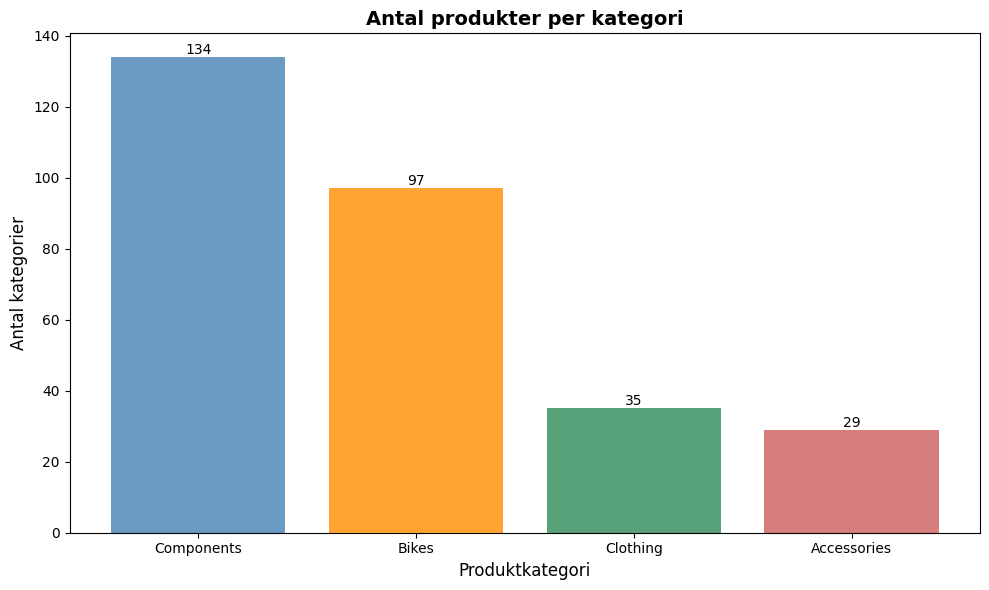

In [3]:
query_vis1 = """
SELECT
    pc.Name AS CategoryName,
    COUNT(DISTINCT p.ProductID) AS ProductCount

FROM Production.ProductCategory pc
INNER JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
GROUP BY pc.Name
ORDER BY ProductCount DESC
"""

df_vis1 = query_df(query_vis1)

fig, ax = plt.subplots(figsize=(10,6))

colors = [
    'steelblue', 'darkorange',
    'seagreen','indianred'
]

bars = ax.bar(
    df_vis1['CategoryName'],
    df_vis1['ProductCount'],
    color=colors[:len(df_vis1)], alpha=0.8
    )

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom'
    )
    

ax.set_xlabel('Produktkategori', fontsize=12)
ax.set_ylabel('Antal kategorier', fontsize=12)
ax.set_title('Antal produkter per kategori', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### Insikter - antal produkter per kategori
Components är största kategori med 134 produkter.
Accessories är minst med 29 produkter.

Detta indikerar på att företaget är starkt fokuserat på komponenter och reservdelar.
Samt att accessories kan vara ett utvecklingsområde.

## Visualisering 2: Total försäljning per produktkategori

### Affärsfråga
Vilka produktkategorier genererar mest intäkter?

### Använda tabeller
- Production.ProductCategory  
- Production.ProductSubcategory  
- Production.Product  
- Sales.SalesOrderDetail  

### Metod
- Tabellerna sammanfogas med JOINs
- Total försäljning beräknas per kategori
- Resultatet sorteras från högst till lägst
- Visualiseras med ett **horisontellt stapeldiagram**

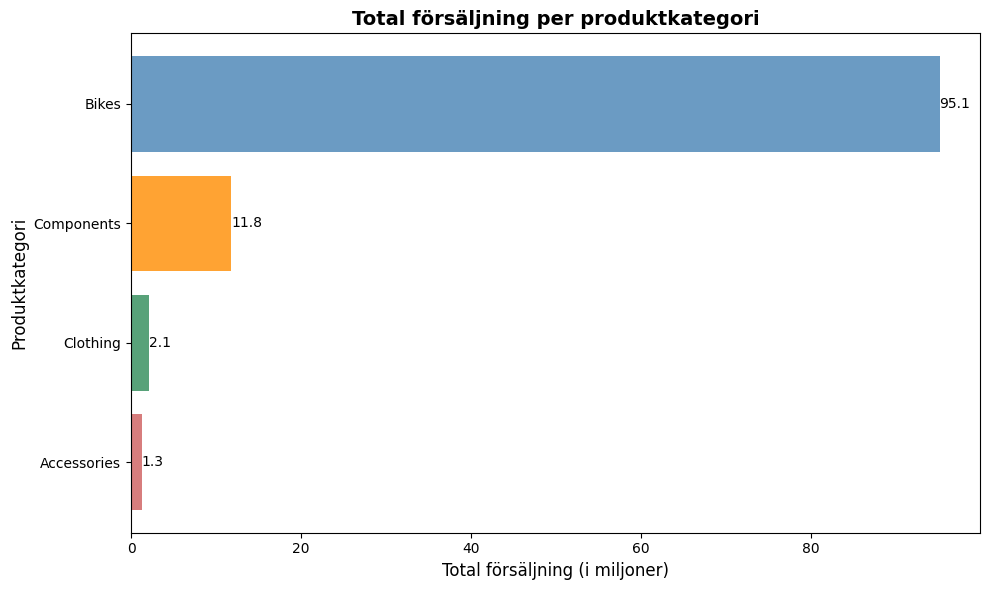

In [4]:
query_vis2 = """
SELECT
    pc.Name AS CategoryName,
    SUM(sod.OrderQty * sod.UnitPrice) AS TotalSales
FROM Production.ProductCategory pc

INNER JOIN Production.ProductSubcategory psc
    ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p
    ON psc.ProductSubcategoryID = p.ProductSubcategoryID
INNER JOIN Sales.SalesOrderDetail sod
    ON p.ProductID = sod.ProductID
GROUP BY pc.Name
ORDER BY TotalSales DESC
"""

df_vis2 = query_df(query_vis2)

df_vis2['TotalSales_M'] = df_vis2['TotalSales'] / 1_000_000

fig, ax = plt.subplots(figsize=(10,6))

bars = ax.barh(
    df_vis2['CategoryName'],
    df_vis2['TotalSales_M'],
    color=colors[:len(df_vis2)], alpha=0.8
)

for bar in bars:
    width = bar.get_width()
    ax.text(
        width,
        bar.get_y() + bar.get_height()/2,
        f'{width:.1f}',
        va='center',
        ha='left'
    )

ax.set_xlabel('Total försäljning (i miljoner)', fontsize=12)
ax.set_ylabel('Produktkategori', fontsize=12)
ax.set_title('Total försäljning per produktkategori', fontsize=14, fontweight='bold')

ax.invert_yaxis()
plt.tight_layout()
plt.show()

### Insikter – total försäljning per produktkategori

Det är tydligt att **Bikes** dominerar försäljningen och står för cirka **95,1 miljoner**, vilket gör detta till företagets absolut största produktkategori sett till intäkter.

I andra änden ligger **Accessories**, som endast når omkring **1,3 miljoner** i försäljning. Det visar att denna kategori spelar en betydligt mindre roll för den totala försäljningen jämfört med de övriga kategorierna.

Försäljningsvärdena har beräknats som **OrderQty * UnitPrice**.

## Visualisering 3: Försäljningstrend över tid

### Affärsfråga
Hur har försäljningen utvecklats över tid?

### Använda tabeller
- Sales.SalesOrderHeader

### Metod
- Försäljning aggregeras per månad baserat på orderdatum
- Resultatet sorteras kronologiskt, från äldsta till senaste månad
- Visualiseras med ett linjediagram för att tydligt visa trenden över tid

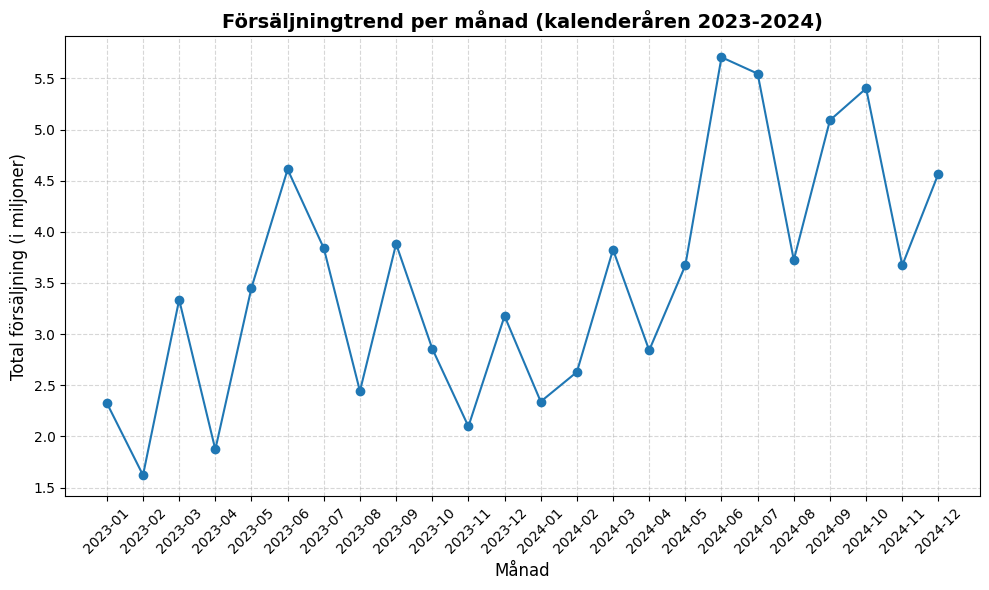

Bästa månad: 2024-06: 5.71 miljoner
Sämsta månad: 2023-02: 1.62 miljoner


In [5]:
query_vis3 = """
SELECT
    FORMAT(OrderDate, 'yyyy-MM') AS YearMonth,
    SUM(TotalDue) AS TotalSales

FROM Sales.SalesOrderHeader
WHERE OrderDate >= '2023-01-01'
AND OrderDate < '2025-01-01'
GROUP BY FORMAT(OrderDate, 'yyyy-MM')
ORDER BY YearMonth ASC
"""

df_vis3 = query_df(query_vis3)

df_vis3['TotalSales_M'] = df_vis3['TotalSales'] / 1_000_000
best_month = df_vis3.loc[df_vis3['TotalSales_M'].idxmax()]
worst_month = df_vis3.loc[df_vis3['TotalSales_M'].idxmin()]

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(
    df_vis3['YearMonth'],
    df_vis3['TotalSales_M'],
    marker='o'
)

ax.set_title('Försäljningtrend per månad (kalenderåren 2023-2024)', fontsize=14, fontweight='bold')
ax.set_xlabel('Månad', fontsize=12)
ax.set_ylabel('Total försäljning (i miljoner)', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.5)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(
    f"Bästa månad: {best_month['YearMonth']}: "
    f"{best_month['TotalSales_M']:.2f} miljoner"
)

print(
    f"Sämsta månad: {worst_month['YearMonth']}: "
    f"{worst_month['TotalSales_M']:.2f} miljoner"
)

### Insikter – försäljningstrend över tid

Försäljningen varierar tydligt över året och följer ett återkommande mönster. Under våren, särskilt runt april och maj, ökar försäljningen markant. Under sommaren avtar försäljningen gradvis och når en lägre nivå mot sensommaren, runt augusti, innan den ökar igen under september.

Den bästa månaden under perioden är **juni 2024** med cirka **5,71 miljoner** i försäljning, medan den svagaste månaden är **februari 2023** med omkring **1,62 miljoner**. Sammantaget tyder detta på att försäljningen är säsongsbetonad snarare än jämnt fördelad över året.

Utöver säsongsmönstret ligger försäljningsnivåerna generellt något högre under 2024 jämfört med 2023, vilket kan tyda på en positiv utveckling över tid.

## Visualisering 4: Försäljning och antal ordrar per år

### Affärsfråga
Hur ser total försäljning och antal ordrar ut per år?

### Använda tabeller
- Sales.SalesOrderHeader

### Metod
- Försäljning och antal ordrar aggregeras per år
- Resultatet sorteras kronologiskt
- Visualiseras med två stapeldiagram för att möjliggöra jämförelse mellan åren

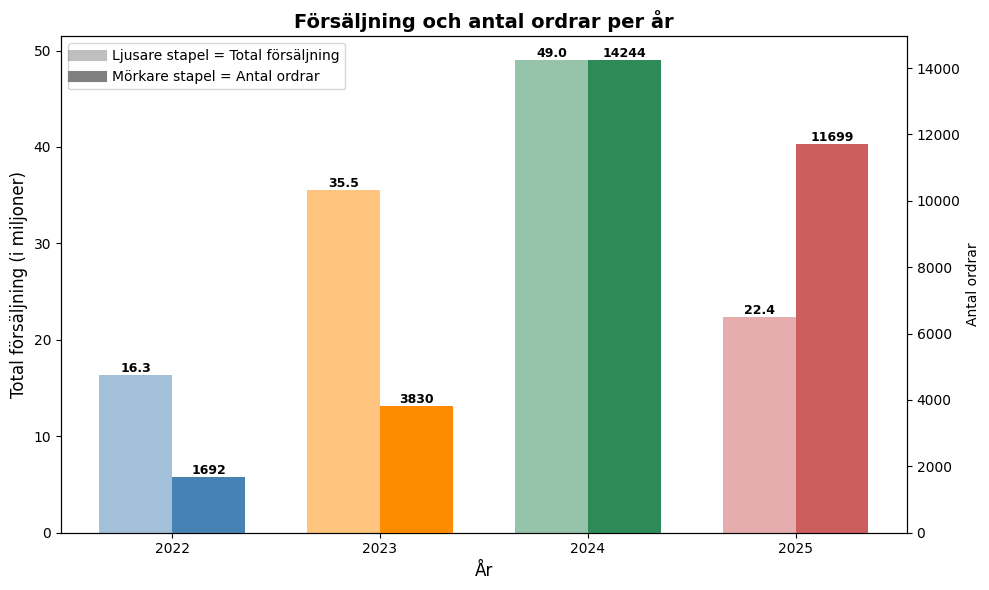

In [14]:
query_vis4 = """
SELECT
    YEAR(OrderDate) AS OrderYear,
    SUM(TotalDue) AS TotalSales,
    COUNT(SalesOrderId) AS OrderCount

FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate)
ORDER BY OrderYear ASC
"""

df_vis4 = query_df(query_vis4)

df_vis4['TotalSales_M'] = df_vis4['TotalSales'] / 1_000_000

years = df_vis4['OrderYear']
x = np.arange(len(years))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10,6))

bars_sales = ax1.bar(
    x - width/2,
    df_vis4['TotalSales_M'],
    width,
    color=colors[:len(df_vis4)],
    alpha=0.5
)

for bar in bars_sales:
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f'{height:.1f}',
        ha='center',
        va='bottom',
        fontsize=9,
        fontweight='bold'
    )

ax1.set_title('Försäljning och antal ordrar per år', fontsize=14, fontweight='bold')
ax1.set_xlabel('År', fontsize=12)
ax1.set_ylabel('Total försäljning (i miljoner)', fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(years)

ax2 = ax1.twinx()

bars_orders = ax2.bar(
    x + width/2,
    df_vis4['OrderCount'],
    width,
    color=colors[:len(df_vis4)],
    alpha=1
)

for bar in bars_orders:
    height = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=9,
        fontweight='bold'
    )

ax2.set_ylabel('Antal ordrar')

ax1.plot([], [], color='grey', alpha=0.5, linewidth=8,
         label='Ljusare stapel = Total försäljning')

ax1.plot([], [], color='grey', alpha=1.0, linewidth=8,
         label='Mörkare stapel = Antal ordrar')

ax1.legend(loc='upper left')

plt.tight_layout()
plt.show()

### Insikter – försäljning och antal ordrar per år

Vid en jämförelse mellan åren är det viktigt att notera att **2023** och **2024** är de enda fullständiga kalenderåren i datamaterialet och därför mest relevanta att jämföra.

Mellan **2023** och **2024** syns en kraftig ökning i antalet ordrar, medan den totala försäljningen ökar i mer begränsad omfattning – från cirka **35,5 miljoner** till **49 miljoner**. Detta tyder på att tillväxten i första hand drivs av fler genomförda köp snarare än en motsvarande ökning i genomsnittligt ordervärde.

Åren **2022** och **2025** innehåller endast delar av året (**8** respektive **6** månader) och bör därför tolkas med försiktighet. Den lägre nivån för dessa år speglar sannolikt datatäckningen snarare än en faktisk förändring i försäljningsutvecklingen.

Sammanfattningsvis är **2024** det år med högst total försäljning, och jämfört med 2023 ökar både försäljning och antal ordrar, även om ökningen är betydligt starkare för antal ordrar än för försäljningen i sig.